<a href="https://colab.research.google.com/github/honggi82/computer_vision/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense, Reshape, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt

(train_X, _), (_, _) = fashion_mnist.load_data() # we need only train_X data

In [2]:
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32') 
train_X = (train_X-127.5) / 127.5 # normalization 

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_X).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [3]:
codings_size = 30 # size of the input noise

generator = Sequential([
    Dense(7 * 7 * 128, input_shape=[codings_size]),
    Reshape([7, 7, 128]),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh")
])
discriminator = Sequential([
    Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=LeakyReLU(0.2),input_shape=[28, 28, 1]),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=LeakyReLU(0.2)),
    BatchNormalization(),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation="sigmoid")
])
gan = Sequential([generator, discriminator])

In [4]:
discriminator.compile(loss="binary_crossentropy", optimizer="Adam")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="Adam")

In [5]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))  
        for X_batch in dataset:
            # training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)   
        plt.show()

Epoch 1/10


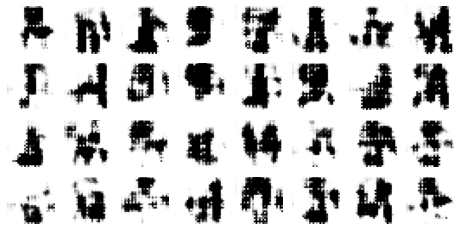

Epoch 2/10


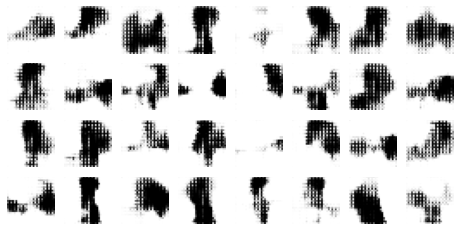

Epoch 3/10


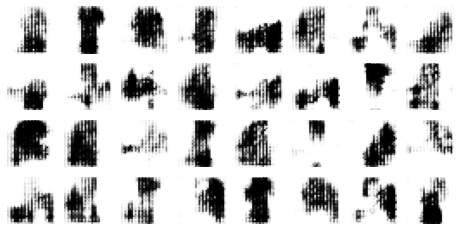

Epoch 4/10


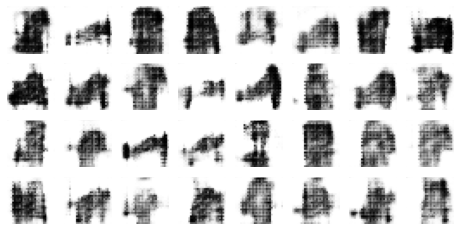

Epoch 5/10


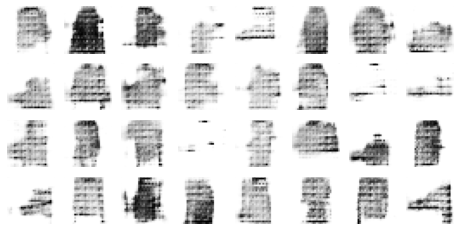

Epoch 6/10


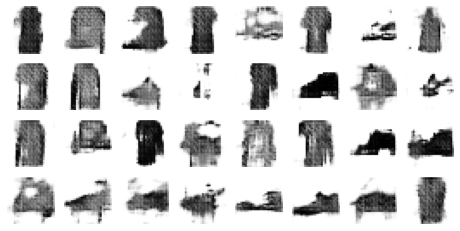

Epoch 7/10


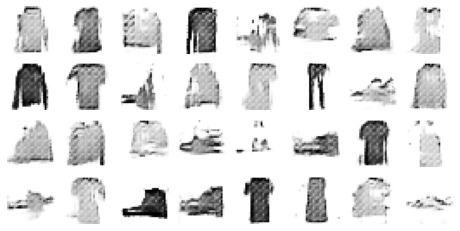

Epoch 8/10


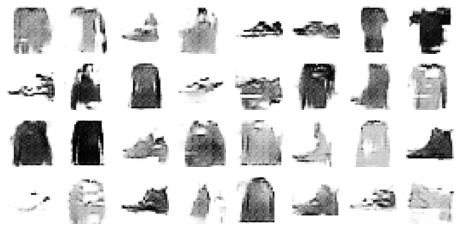

Epoch 9/10


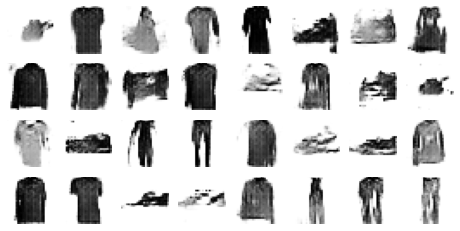

Epoch 10/10


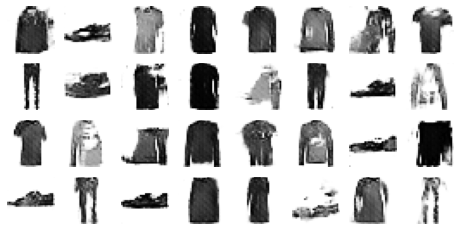

In [6]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

1/1 [==============================] - 0s 116ms/step


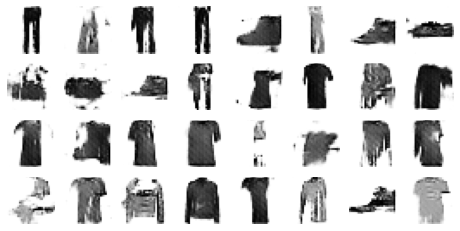

In [7]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8) 